## Libraries

In [1]:
import os
import warnings 
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression     
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
import shap

## Data import

from Kaggle 

_kaggle은 설치되어 있는데 kagglehub는 따로 `!pip install` 해주었어야 하네요._

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\djroz\.cache\kagglehub\datasets\priyamchoksi\credit-card-transactions-dataset\versions\1


In [4]:
data = pd.read_csv(path+"/credit_card_transactions.csv")

In [5]:
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


인덱스였던 column `'Unnamed: 0'`은 의미가 없으므로 drop

In [6]:
df = data.copy()
df.drop(columns=['Unnamed: 0'], inplace=True)

## EDA

### <div style="color:rgb(4, 108, 211);"> **1. summary: types and missing values** </div>


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [8]:
# number and percentage of missing values according to columns
{col: [df[col].isnull().sum(), f'% {np.round(np.mean(df[col].isnull()*100), 3)}'
      ] for col in df.columns if df[col].isnull().any()}

{'merch_zipcode': [195973, '% 15.114']}

<Axes: >

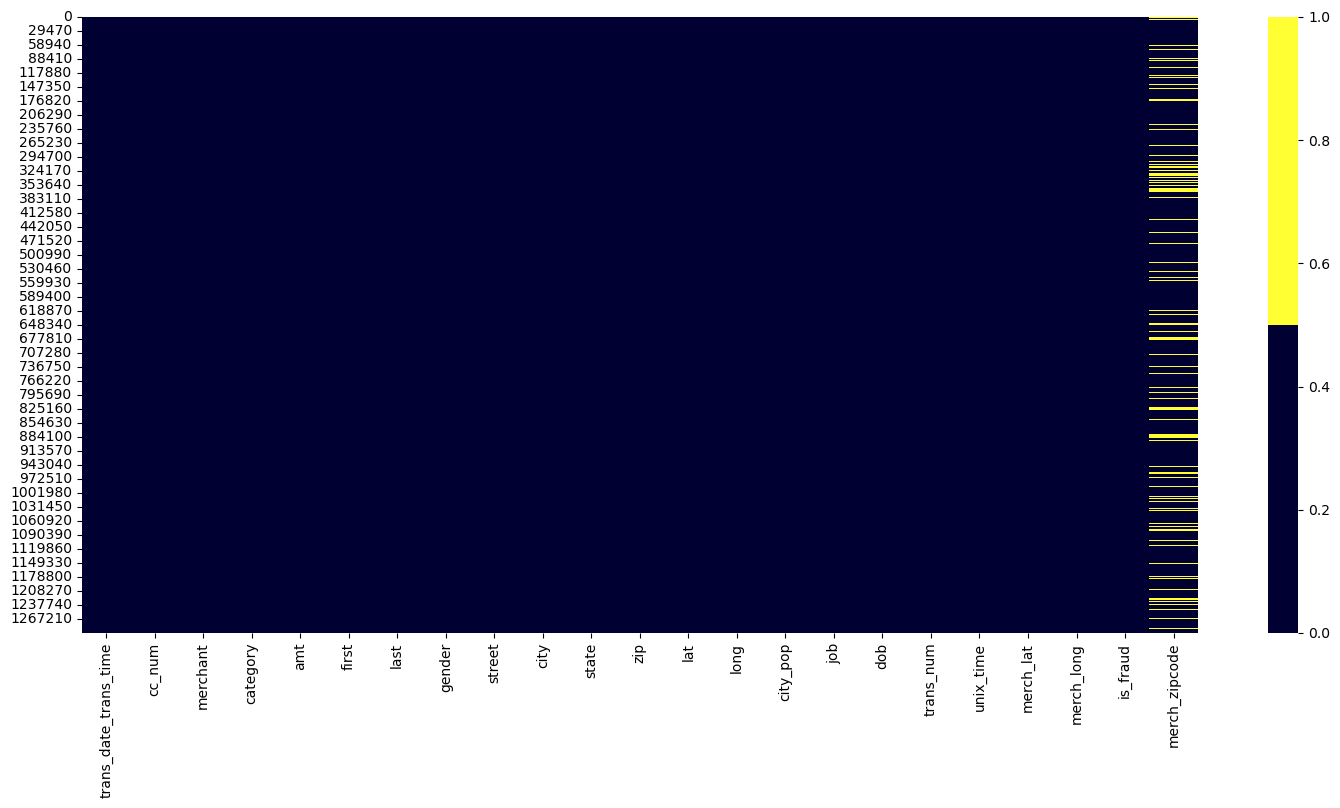

In [9]:
plt.figure(figsize=(18,8))

colors = ['#000033', '#FFFF33'] 
sns.heatmap(df.isnull(), cmap=sns.color_palette(colors))

In [10]:
df['merch_zipcode'].isna().sum()

195973

* zipcode에만 결측치가 존재하는 것을 확인  
* 데이터레코드 순서와는 무관하게 소실된 상태인 것도 확인

### <div style="color:rgb(4, 108, 211);"> **2. meaning: columns and values range** </div>


* trans_date_trans_time - Transaction datetime
* cc_num - Credit card number
* merchant - Merchant(Company) name
* category - Merchant category
* amt - Transaction amount

* first - Customer's first name
* last - Customer's last name
* gender - Customer's gender
* street - Customer's street address
* city - Customer's city
* state - Customer's state
* zip - Customer's ZIP code of transaction place
* lat - Customer's latitudee of transaction place
* long - Customer's longitudee of transaction place
* city_pop - City population
* job - Customer's occupation
* dob - Customer's date of birth

* trans_num - Transaction ID
* unix_time - Transaction time in Unix time stamp
* merch_lat - Merchant's latitude
* merch_long - Merchant's longitude
* is_fraud - Fraud indicator (0 or 1)
* merch_zipcode - Merchant's ZIP code

🤫 So we have to think about...  

    - cc_num은 의미없는 숫자형으로 거래유저 id 취급
    - merchant는 거래가 일어난난 업소명으로 추정
    - 위치와 관련된 정보는 거래회원의 회원 정보이고, 이어 나오는 merch_lat/long이 거래업소의 위치로 추측됨
    - trans_num이 데이터의 unique_id


In [11]:
pd.options.display.float_format = '{:,.2f}'.format
df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
count,"1,296,675.00","1,296,675.00","1,296,675.00","1,296,675.00","1,296,675.00","1,296,675.00","1,296,675.00","1,296,675.00","1,296,675.00","1,296,675.00","1,100,702.00"
mean,"417,192,042,079,726,656.00",70.35,"48,800.67",38.54,-90.23,"88,824.44","1,349,243,636.73",38.54,-90.23,0.01,"46,825.75"
std,"1,308,806,447,000,789,248.00",160.32,"26,893.22",5.08,13.76,"301,956.36","12,841,278.42",5.11,13.77,0.08,"25,834.00"
min,"60,416,207,185.00",1.00,"1,257.00",20.03,-165.67,23.00,"1,325,376,018.00",19.03,-166.67,0.00,"1,001.00"
25%,"180,042,946,491,150.00",9.65,"26,237.00",34.62,-96.80,743.00,"1,338,750,742.50",34.73,-96.90,0.00,"25,114.00"
50%,"3,521,417,320,836,166.00",47.52,"48,174.00",39.35,-87.48,"2,456.00","1,349,249,747.00",39.37,-87.44,0.00,"45,860.00"
75%,"4,642,255,475,285,942.00",83.14,"72,042.00",41.94,-80.16,"20,328.00","1,359,385,375.50",41.96,-80.24,0.00,"68,319.00"
max,"4,992,346,398,065,154,048.00","28,948.90","99,783.00",66.69,-67.95,"2,906,700.00","1,371,816,817.00",67.51,-66.95,1.00,"99,403.00"


In [12]:
df.describe(include='object')

,trans_date_trans_time,merchant,category,first,last,gender,street,city,state,job,dob,trans_num
count,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675
unique,1274791,693,14,352,481,2,983,894,51,494,968,1296675
top,2019-04-22 16:02:01,fraud_Kilback LLC,gas_transport,Christopher,Smith,F,0069 Robin Brooks Apt. 695,Birmingham,TX,Film/video editor,1977-03-23,0b242abb623afc578575680df30655b9
freq,4,4403,131659,26669,28794,709863,3123,5617,94876,9779,5636,1


### <div style="color:rgb(4, 108, 211);"> **3. meaning: columns and values range** </div>
